# Import Data

In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime as dt
from datetime import date, timedelta
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import requests
from darksky import forecast

In [3]:
from api_key import ds

In [4]:
# Import dataframe, rename cols
df = pd.read_csv('Datasets/ausraindata.csv')
df = df.rename({'MinTemp':'TempLow', 'MaxTemp':'TempHigh'}, axis=1)
df.shape

(142193, 24)

In [5]:
# Drop following day measured rainfall, drop data with no rain
df = df.drop('RISK_MM', axis=1)
df = df.dropna(subset=['Rainfall', 'RainToday'])
df.shape

(140787, 23)

In [6]:
df.keys()

Index(['Date', 'Location', 'TempLow', 'TempHigh', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [7]:
# new_df = pd.read_csv('Datasets/final_data.csv', index_col=0)
# new_df.shape

In [11]:
31455/140787

0.2234226171450489

# Data Cleaning

In [7]:
# Function to turn yes and no values into 1 and 0 values
def trans_bools(df, col):
    df[col] = np.where(df[col]=='Yes', 1, 0)
    return df

In [8]:
# Function to transform date data
def trans_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [9]:
# Function to transform cloud data
def trans_cloud(df):
    df['Cloud9am'] = df['Cloud9am'] / 8
    df['Cloud3pm'] = df['Cloud3pm'] / 8
    return df

In [10]:
# Function to add latitude longitude data
def lat_lon(df):
    lat_lon = [
        (-34.9281805, 138.5999312),(-35.0247822, 117.883608),(-36.0804766, 146.9162795),
        (-23.6983884, 133.8812885),(-35.8348792, 149.9957662),(-37.5622632, 143.8607215),
        (-36.7588767, 144.2825931),(-27.4689682, 153.0234991),(-16.9206657, 145.7721854),
        (-35.2975906, 149.1012676),(-31.4983333, 145.8344444),(-30.2962407, 153.1135293),
        (-37.9225444, 141.2766551),(-12.46044, 130.8410469),(-28.0023731, 153.4145987),
        (-42.8825088, 147.3281233),(-14.4642313, 132.2638568),(-41.4340813, 147.1373496),
        (-37.8142176, 144.9631608),(-37.667111000000006, 144.83348076679553),
        (-34.1847265, 142.1624972),(-29.4617202, 149.8407153),(-37.8246698, 140.7820067624113),
        (-35.5297196, 148.7726345),(-32.9272881, 151.7812534),(-35.4325283, 141.2833187),
        (-33.2816667, 151.5677778),(-29.0328038, 167.9483137),(-34.4693354, 138.9939006),
        (-31.6739604, 116.01754351808194),(-33.7510792, 150.6941684),(-31.9527121, 115.8604796),
        (-31.9431218, 115.9668059888865),(-38.363435, 141.6056055089348),
        (-37.80745, 144.99071757972087),(-38.106605, 147.06794525572298),
        (-32.9815347, 121.6439417),(-33.8548157, 151.2164539),(-33.9498935, 151.18196819346016),
        (-19.2569391, 146.8239537),(-35.4209771, 149.0921341),(-25.3455545, 131.03696147470208),
        (-35.115, 147.3677778),(-34.9776796, 116.7310063),(-37.7110022, 145.083635),
        (-32.815, 151.8427778),(-34.0263348, 115.1004768),(-34.4243941, 150.89385),
        (-31.1999142, 136.8253532)]
    city_names = sorted(df['Location'].unique())
    loc_dict = dict(zip(city_names, lat_lon))
    df['Lat_Lon'] = df['Location'].apply(lambda x: loc_dict[x])
    return df

In [11]:
# Funciton to apply data cleaning
def clean_data(df):
    for col in ['RainToday', 'RainTomorrow']:
        df = trans_bools(df, col)
    df = trans_date(df)
    df = trans_cloud(df)
    df = lat_lon(df)
    return df

df = clean_data(df)

In [12]:
df.keys()

Index(['Date', 'Location', 'TempLow', 'TempHigh', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Lat_Lon'],
      dtype='object')

# Fill in Missing Data

In [13]:
conversions = {
    'Date':'x', 'Location':'x', 'TempLow':'((x-32)/1.8)', 'TempHigh':'((x-32)/1.8)',
    'Rainfall':'(x*25.4)','Sunshine':'x', 'WindGustDir':'x', 'WindGustSpeed':'(x*1.609)',
    'WindDir9am':'x', 'WindDir3pm':'x', 'WindSpeed9am':'(x*1.609)', 'WindSpeed3pm':'(x*1.609)',
    'Humidity9am':'x', 'Humidity3pm':'x', 'Pressure9am':'x', 'Pressure3pm':'x', 'Cloud9am':'x',
    'Cloud3pm':'x', 'Temp9am':'((x-32)/1.8)', 'Temp3pm':'((x-32)/1.8)', 'RainToday':'x',
    'RainTomorrow':'x'}

In [14]:
# List of dataframes per city
cities = []
for location, df_location in df.groupby('Location'):
    cities.append(df_location)
city_names = sorted(df['Location'].unique())
cities = dict(zip(city_names, cities))
len(cities)

49

In [15]:
# Columns with null values
nulls = df.isnull().sum()
nulls

Date                 0
Location             0
TempLow            468
TempHigh           307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustDir       9163
WindGustSpeed     9105
WindDir9am        9660
WindDir3pm        3670
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
RainToday            0
RainTomorrow         0
Lat_Lon              0
dtype: int64

In [16]:
# # Dark Sky API loop for missing data, convert units to metric
# for city in cities.values():
#     loc_call = ds, city['Lat_Lon'].iloc[0][0], city['Lat_Lon'].iloc[0][1]
#     for i, r in city.iterrows():
#         if city.isnull().loc[i].any():
#             try:
#                 date_call = r['Date'].isoformat()
#                 api_call = forecast(*loc_call, time=date_call)
#                 api_dict = {
#                     'TempLow':(api_call.daily.data[0].temperatureMin-32)/1.8,
#                     'TempHigh':(api_call.daily.data[0].temperatureMax-32)/1.8,
#                     'Rainfall':city['Rainfall'].median(),
#                     'Evaporation':city['Evaporation'].median(),
#                     'Sunshine':city['Evaporation'].median(),
#                     'WindGustSpeed':api_call.daily.data[0].windGust*1.609,
#                     'WindSpeed9am':api_call.hourly.data[9].windSpeed*1.609,
#                     'WindSpeed3pm':api_call.hourly.data[15].windSpeed*1.609,
#                     'Humidity9am':api_call.hourly.data[9].humidity*100,
#                     'Humidity3pm':api_call.hourly.data[15].humidity*100,
#                     'Pressure9am':api_call.hourly.data[9].pressure,
#                     'Pressure3pm':api_call.hourly.data[15].pressure,
#                     'Cloud9am':api_call.hourly.data[9].cloudCover,
#                     'Cloud3pm':api_call.hourly.data[15].cloudCover,
#                     'Temp9am':(api_call.hourly.data[9].temperature-32)/1.8,
#                     'Temp3pm':(api_call.hourly.data[15].temperature-32)/1.8}
#                 # df.isnull().iloc[i]
#                 for c in list(city.columns):
#                     if pd.isnull(r[c]):
#                         city[c][i] = api_dict[c]
#                         print(i, c, city[c][i])
#                         # r[c] = api_dict[c]
#                         # print(i, c, r[c])
#             except:
#                 print(i, 'ERROR')
#     filename = city['Location'].iloc[0]
#     city.to_csv(f'{filename}.csv')

# Combine City Dataframes

In [43]:
new_df = pd.DataFrame(columns=list(df.columns))
new_df.shape

(0, 24)

In [ ]:
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

continuous_cols = ['TempLow', 'TempHigh', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                   'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                   'Cloud3pm', 'Temp9am', 'Temp3pm']

for city in city_names:
    temp_df = pd.read_csv(f'Datasets/{city}.csv', index_col=0)
    for col in categorical_cols:
        temp_df[col].fillna(method = 'bfill', inplace=True)
    for col in continuous_cols:
        col_median = temp_df[col].median()
        temp_df[col].fillna(col_median, inplace=True)
    new_df = pd.concat([new_df, temp_df])
del temp_df
    
for col in categorical_cols:
    new_df[col].fillna(method = 'bfill', inplace=True)
for col in continuous_cols:
    col_median = new_df[col].median()
    new_df[col].fillna(col_median, inplace=True)
    
new_df.shape

In [44]:
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

continuous_cols = ['TempLow', 'TempHigh', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                   'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                   'Cloud3pm', 'Temp9am', 'Temp3pm']

for city in city_names:
    temp_df = pd.read_csv(f'Datasets/{city}.csv', index_col=0)
    for col in categorical_cols:
        temp_df[col].fillna(method = 'bfill', inplace=True)
    for col in continuous_cols:
        col_median = temp_df[col].median()
        temp_df[col].fillna(col_median, inplace=True)
    new_df = pd.concat([new_df, temp_df])
del temp_df
    
for col in categorical_cols:
    new_df[col].fillna(method = 'bfill', inplace=True)
for col in continuous_cols:
    col_median = new_df[col].median()
    new_df[col].fillna(col_median, inplace=True)
    
new_df.shape

(140787, 24)

In [35]:
# new_df.to_csv('Datasets/final_data.csv')

In [36]:
# List of dataframes per city, after filling null values
new_cities = []
for location, df_location in new_df.groupby('Location'):
    new_cities.append(df_location)
# city_names = sorted(df['Location'].unique())
new_cities = dict(zip(city_names, new_cities))
len(new_cities)

49

# Feature Creation

In [20]:
# new_df = pd.read_csv('Datasets/final_data.csv', index_col=0)
# new_df.shape

In [21]:
# Function to create average rain per city feature
def avg_rain(df):   
    city_names = sorted(df['Location'].unique())
    avg_rain = list(df.groupby('Location')['Rainfall'].mean())
    rain_dict = dict(zip(city_names, avg_rain))
    df['Mean_Rainfall'] = df['Location'].apply(lambda x: rain_dict[x])
    return df

In [22]:
# Function to turn location data into dummy variables
def dummies_loc(df):
    dummies = pd.get_dummies(df['Location'], prefix='Loc', drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    return df

In [23]:
# Function to turn wind direction data into dummy variables
def dummies_wind(df):
    for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        dirs = {'E':'E', 'ENE':'NE', 'ESE':'SE', 'N':'N', 'NE':'NE', 'NNE':'NE',
                'NNW':'NW', 'NW':'NW', 'S':'S', 'SE':'SE', 'SSE':'SE', 'SSW':'SW',
                'SW':'SW', 'W':'W', 'WNW':'NW', 'WSW':'SW'}
        df[col] = df[col].map(dirs)
    dummies_gust = pd.get_dummies(df['WindGustDir'], prefix='WDGust', drop_first=True)
    dummies_9am = pd.get_dummies(df['WindDir9am'], prefix='WD9am', drop_first=True)
    dummies_3pm = pd.get_dummies(df['WindDir3pm'], prefix='WD3pm', drop_first=True)
    df = pd.concat([df, dummies_gust, dummies_9am, dummies_3pm], axis=1)
    df = df.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)
    return df

In [24]:
# # Function to turn dates into season dummy variables
# def dummies_seasons(df):
# #     df['Date'] = pd.to_datetime(df['Date'])
#     # df['Year'] = df['Date'].map(lambda d: d.year)
#     df['Fall'] = 0
#     df['Winter'] = 0
#     df['Spring'] = 0
#     seasons = {
#         2007:{'Fall': pd.date_range('2007-03-21', '2007-06-21'),
#               'Winter': pd.date_range('2007-06-21', '2007-09-23'),
#               'Spring': pd.date_range('2007-09-23', '2007-12-22')},
#         2008:{'Fall': pd.date_range('2008-03-20', '2008-06-21'),
#               'Winter': pd.date_range('2008-06-21', '2008-09-22'),
#               'Spring': pd.date_range('2008-09-22', '2008-12-21')},
#         2009:{'Fall': pd.date_range('2009-03-20', '2009-06-21'),
#               'Winter': pd.date_range('2009-06-21', '2009-09-22'),
#               'Spring': pd.date_range('2009-09-22', '2009-12-21')},
#         2010:{'Fall': pd.date_range('2010-03-20', '2010-06-21'),
#               'Winter': pd.date_range('2010-06-21', '2010-09-23'),
#               'Spring': pd.date_range('2010-09-23', '2010-12-21')},
#         2011:{'Fall': pd.date_range('2011-03-20', '2011-06-21'),
#               'Winter': pd.date_range('2011-06-21', '2011-09-23'),
#               'Spring': pd.date_range('2011-09-23', '2011-12-22')},
#         2012:{'Fall': pd.date_range('2012-03-20', '2012-06-20'),
#               'Winter': pd.date_range('2012-06-20', '2012-09-22'),
#               'Spring': pd.date_range('2012-09-22', '2012-12-21')},
#         2013:{'Fall': pd.date_range('2013-03-20', '2013-06-21'),
#               'Winter': pd.date_range('2013-06-21', '2013-09-22'),
#               'Spring': pd.date_range('2013-09-22', '2013-12-21')},
#         2014:{'Fall': pd.date_range('2014-03-20', '2014-06-21'),
#               'Winter': pd.date_range('2014-06-21', '2014-09-23'),
#               'Spring': pd.date_range('2014-09-23', '2014-12-21')},
#         2015:{'Fall': pd.date_range('2015-03-20', '2015-06-21'),
#               'Winter': pd.date_range('2015-06-21', '2015-09-23'),
#               'Spring': pd.date_range('2015-09-23', '2015-12-22')},
#         2016:{'Fall': pd.date_range('2016-03-20', '2016-06-20'),
#               'Winter': pd.date_range('2016-06-20', '2016-09-22'),
#               'Spring': pd.date_range('2016-09-22', '2016-12-21')},
#         2017:{'Fall': pd.date_range('2017-03-20', '2017-06-21'),
#               'Winter': pd.date_range('2017-06-21', '2017-09-22'),
#               'Spring': pd.date_range('2017-09-22', '2017-12-21')}
#     }
#     for year in seasons.keys():
#         filt_year = df['Date'].year == year
#         for season in seasons[year].keys():
#             # print(seasons[year][season])
#             filt_season = df['Date'] in seasons[year][season]
#             df[season] = np.where(filt_year & filt_season, 1, df[season])
#     return df

In [25]:
# def season_of_date(date):
#     year = str(date.year)
#     seasons = {'Spring': pd.date_range(start='21-03-'+year, end='20/06/'+year),
#                'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
#                'Fall': pd.date_range(start=year+'-03-20', end=year)}
#     if date in seasons['Spring']:
#         return 'Spring'
#     if date in seasons['Summer']:
#         return 'Summer'
#     if date in seasons['Autumn']:
#         return 'Fall'
#     else:
#         return 'Winter'

# # Assuming df has a date column of type `datetime`
# df['season'] = df.date.map(season_of_date)

In [26]:
#     seasons = {
#         2007:{'Fall': pd.date_range('2007-03-21', '2007-06-21'),
#               'Winter': pd.date_range('2007-06-21', '2007-09-23'),
#               'Spring': pd.date_range('2007-09-23', '2007-12-22')},
#         2008:{'Fall': pd.date_range('2008-03-20', '2008-06-21'),
#               'Winter': pd.date_range('2008-06-21', '2008-09-22'),
#               'Spring': pd.date_range('2008-09-22', '2008-12-21')},
#         2009:{'Fall': pd.date_range('2009-03-20', '2009-06-21'),
#               'Winter': pd.date_range('2009-06-21', '2009-09-22'),
#               'Spring': pd.date_range('2009-09-22', '2009-12-21')},
#         2010:{'Fall': pd.date_range('2010-03-20', '2010-06-21'),
#               'Winter': pd.date_range('2010-06-21', '2010-09-23'),
#               'Spring': pd.date_range('2010-09-23', '2010-12-21')},
#         2011:{'Fall': pd.date_range('2011-03-20', '2011-06-21'),
#               'Winter': pd.date_range('2011-06-21', '2011-09-23'),
#               'Spring': pd.date_range('2011-09-23', '2011-12-22')},
#         2012:{'Fall': pd.date_range('2012-03-20', '2012-06-20'),
#               'Winter': pd.date_range('2012-06-20', '2012-09-22'),
#               'Spring': pd.date_range('2012-09-22', '2012-12-21')},
#         2013:{'Fall': pd.date_range('2013-03-20', '2013-06-21'),
#               'Winter': pd.date_range('2013-06-21', '2013-09-22'),
#               'Spring': pd.date_range('2013-09-22', '2013-12-21')},
#         2014:{'Fall': pd.date_range('2014-03-20', '2014-06-21'),
#               'Winter': pd.date_range('2014-06-21', '2014-09-23'),
#               'Spring': pd.date_range('2014-09-23', '2014-12-21')},
#         2015:{'Fall': pd.date_range('2015-03-20', '2015-06-21'),
#               'Winter': pd.date_range('2015-06-21', '2015-09-23'),
#               'Spring': pd.date_range('2015-09-23', '2015-12-22')},
#         2016:{'Fall': pd.date_range('2016-03-20', '2016-06-20'),
#               'Winter': pd.date_range('2016-06-20', '2016-09-22'),
#               'Spring': pd.date_range('2016-09-22', '2016-12-21')},
#         2017:{'Fall': pd.date_range('2017-03-20', '2017-06-21'),
#               'Winter': pd.date_range('2017-06-21', '2017-09-22'),
#               'Spring': pd.date_range('2017-09-22', '2017-12-21')}
#     }

In [37]:
# Function to apply all features to data
def apply_features(df):
    df = avg_rain(df)
    # df = dummies_loc(df)
    df = dummies_wind(df)
    # df = dummies_seasons(df)
    return df

In [38]:
new_df = apply_features(new_df)
new_df.shape

(140787, 43)

# Adjust Outliers

In [7]:
# Function transform extreme values
def ext_values(df, extreme_cols):
    copy = df.copy()
    for col in extreme_cols:
        std = copy[col].std()
        mean = copy[col].mean()
        value = mean+(5*std)
        copy[col] = copy[col].apply(lambda x: value if (np.abs(x-mean) > 5*std) else x)
    return copy

In [8]:
extreme_cols = new_df.drop([
    'RainToday', 'RainTomorrow', 'Date', 'Location', 'Lat_Lon', 'WDGust_N',
    'WDGust_NE', 'WDGust_NW', 'WDGust_S', 'WDGust_SE', 'WDGust_SW', 'WDGust_W',
    'WD9am_N', 'WD9am_NE', 'WD9am_NW', 'WD9am_S', 'WD9am_SE', 'WD9am_SW',
    'WD9am_W', 'WD3pm_N', 'WD3pm_NE', 'WD3pm_NW', 'WD3pm_S', 'WD3pm_SE',
    'WD3pm_SW', 'WD3pm_W'], axis=1)

new_df = ext_values(new_df, extreme_cols)

In [95]:
# new_df.to_csv('Datasets/final_data.csv')

In [ ]:
# new_df.to_csv('Datasets/final_data_trans_outliers.csv')

# EDA

In [4]:
new_df = pd.read_csv('Datasets/final_data.csv', index_col=0)
new_df.shape

(140787, 43)

In [5]:
new_df.keys()

Index(['Date', 'Location', 'TempLow', 'TempHigh', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow',
       'Lat_Lon', 'Mean_Rainfall', 'WDGust_N', 'WDGust_NE', 'WDGust_NW',
       'WDGust_S', 'WDGust_SE', 'WDGust_SW', 'WDGust_W', 'WD9am_N', 'WD9am_NE',
       'WD9am_NW', 'WD9am_S', 'WD9am_SE', 'WD9am_SW', 'WD9am_W', 'WD3pm_N',
       'WD3pm_NE', 'WD3pm_NW', 'WD3pm_S', 'WD3pm_SE', 'WD3pm_SW', 'WD3pm_W'],
      dtype='object')

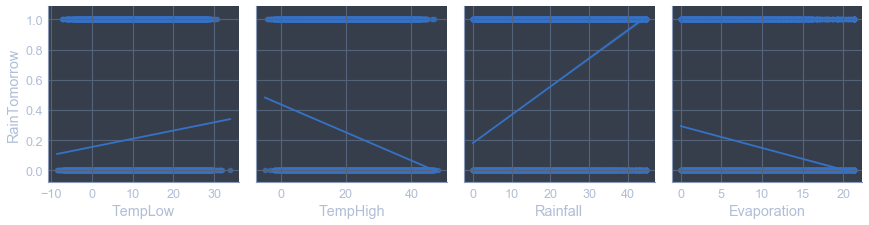

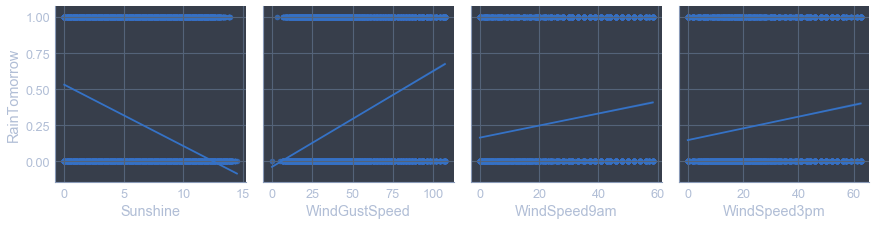

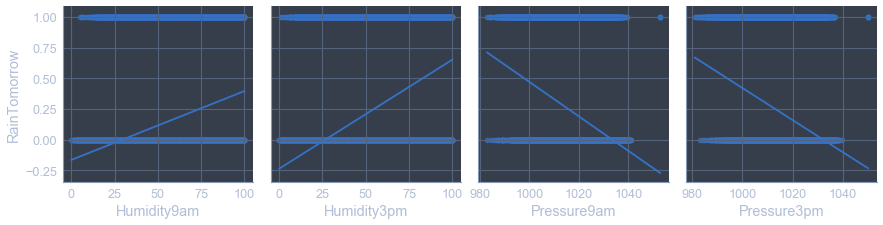

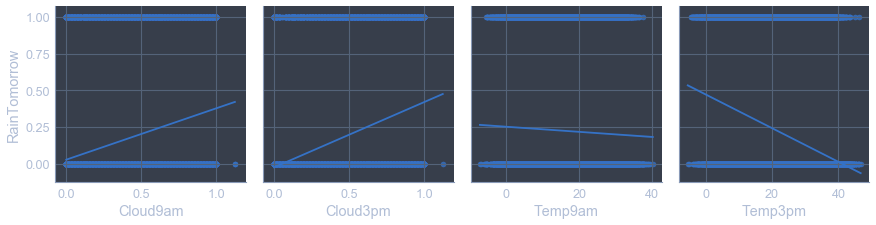

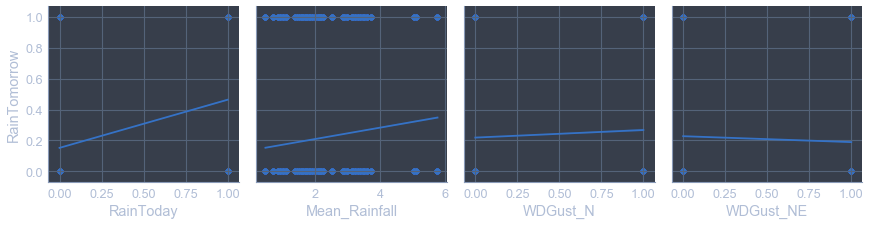

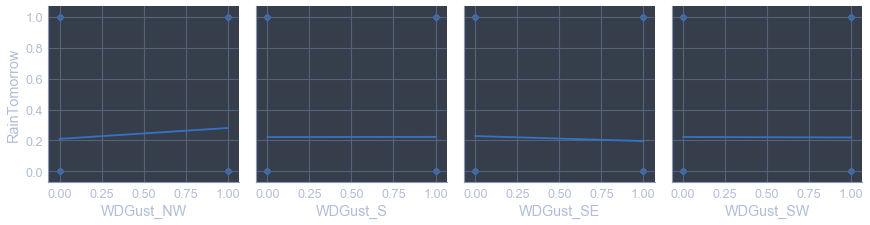

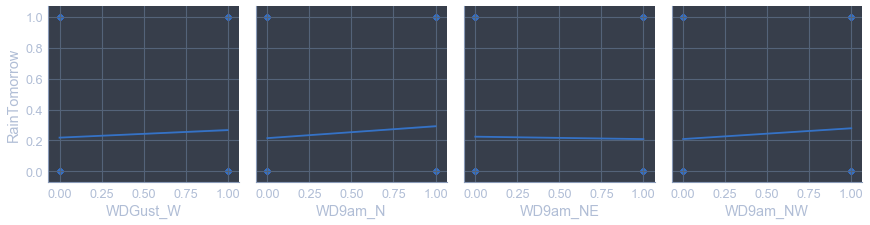

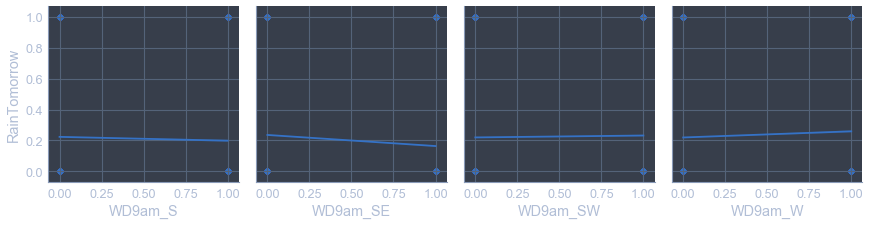

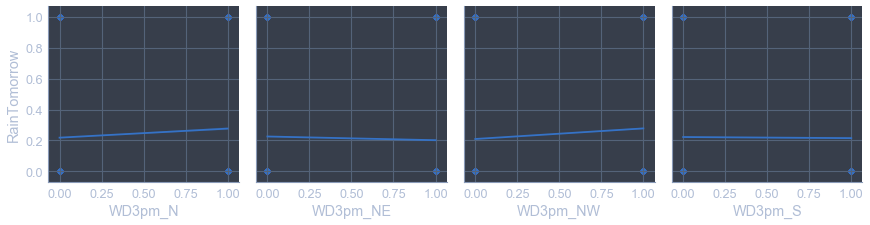

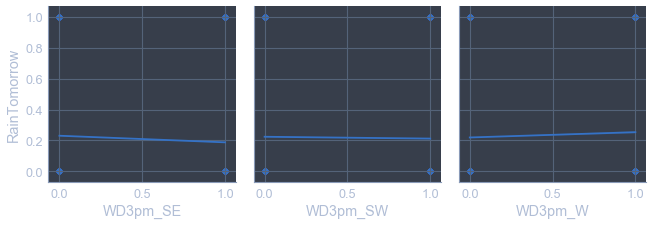

In [9]:
# Function to plot each feature vs target variable
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, x_vars=row, y_vars='RainTomorrow', kind='reg', height=3)
    return plt.show()

features = new_df.drop(['RainTomorrow', 'Date', 'Location', 'Lat_Lon'], axis=1).keys()
pplot_features(new_df, features)

In [60]:
# Function to create correlation matrix
def corr_matrix(df):
    corr = df.corr()
    return corr.style.background_gradient(cmap='coolwarm').set_precision(2)

corr_df = new_df.drop([
    'Date', 'Location', 'Lat_Lon', 'WDGust_N', 'WDGust_NE', 'WDGust_NW',
    'WDGust_S', 'WDGust_SE', 'WDGust_SW', 'WDGust_W', 'WD9am_N', 'WD9am_NE',
    'WD9am_NW', 'WD9am_S', 'WD9am_SE', 'WD9am_SW', 'WD9am_W', 'WD3pm_N',
    'WD3pm_NE', 'WD3pm_NW', 'WD3pm_S', 'WD3pm_SE', 'WD3pm_SW', 'WD3pm_W'], axis=1)
corr_matrix(corr_df)

,TempLow,TempHigh,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Mean_Rainfall
TempLow,1.00,0.74,0.11,0.42,0.10,0.16,0.18,0.18,-0.24,-0.00,-0.43,-0.44,0.06,0.01,0.90,0.71,0.06,0.08,0.38
TempHigh,0.74,1.00,-0.11,0.51,0.34,0.07,0.01,0.05,-0.51,-0.51,-0.31,-0.40,-0.24,-0.23,0.89,0.98,-0.23,-0.16,0.11
Rainfall,0.11,-0.11,1.00,-0.06,-0.18,0.14,0.09,0.07,0.27,0.30,-0.19,-0.14,0.21,0.18,-0.01,-0.11,0.62,0.28,0.14
Evaporation,0.42,0.51,-0.06,1.00,0.35,0.17,0.17,0.11,-0.44,-0.34,-0.23,-0.26,-0.19,-0.18,0.48,0.49,-0.16,-0.10,-0.03
Sunshine,0.10,0.34,-0.18,0.35,1.00,0.00,0.06,0.06,-0.37,-0.43,0.02,-0.02,-0.49,-0.50,0.24,0.36,-0.23,-0.31,-0.03
WindGustSpeed,0.16,0.07,0.14,0.17,0.00,1.00,0.59,0.66,-0.22,-0.05,-0.44,-0.40,0.06,0.10,0.14,0.04,0.14,0.22,-0.02
WindSpeed9am,0.18,0.01,0.09,0.17,0.06,0.59,1.00,0.52,-0.27,-0.03,-0.22,-0.17,0.02,0.07,0.13,0.00,0.10,0.09,0.01
WindSpeed3pm,0.18,0.05,0.07,0.11,0.06,0.66,0.52,1.00,-0.15,0.02,-0.29,-0.26,0.04,0.03,0.16,0.03,0.08,0.09,0.11
Humidity9am,-0.24,-0.51,0.27,-0.44,-0.37,-0.22,-0.27,-0.15,1.00,0.67,0.14,0.18,0.38,0.30,-0.48,-0.50,0.35,0.26,0.12
Humidity3pm,-0.00,-0.51,0.30,-0.34,-0.43,-0.05,-0.03,0.02,0.67,1.00,-0.02,0.06,0.43,0.44,-0.23,-0.56,0.38,0.44,0.34


# Unused Code

In [18]:
# city_names = ['Adelaide','Albany','Albury','AliceSprings','BadgerysCreek',
#               'Ballarat','Bendigo','Brisbane','Cairns','Canberra','Cobar','CoffsHarbour',
#               'Dartmoor','Darwin','GoldCoast','Hobart','Katherine','Launceston','Melbourne',
#               'MelbourneAirport','Mildura','Moree','MountGambier','MountGinini','Newcastle',
#               'Nhil','NorahHead','NorfolkIsland','Nuriootpa','PearceRAAF','Penrith','Perth',
#               'PerthAirport','Portland','Richmond','Sale','SalmonGums','Sydney','SydneyAirport',
#               'Townsville','Tuggeranong','Uluru','WaggaWagga','Walpole','Watsonia','Williamtown',
#               'Witchcliffe','Wollongong','Woomera']

# lat_lon = [(-34.9281805, 138.5999312),(-35.0247822, 117.883608),(-36.0804766, 146.9162795),
#            (-23.6983884, 133.8812885),(-35.8348792, 149.9957662),(-37.5622632, 143.8607215),
#            (-36.7588767, 144.2825931),(-27.4689682, 153.0234991),(-16.9206657, 145.7721854),
#            (-35.2975906, 149.1012676),(-31.4983333, 145.8344444),(-30.2962407, 153.1135293),
#            (-37.9225444, 141.2766551),(-12.46044, 130.8410469),(-28.0023731, 153.4145987),
#            (-42.8825088, 147.3281233),(-14.4642313, 132.2638568),(-41.4340813, 147.1373496),
#            (-37.8142176, 144.9631608),(-37.667111000000006, 144.83348076679553),
#            (-34.1847265, 142.1624972),(-29.4617202, 149.8407153),(-37.8246698, 140.7820067624113),
#            (-35.5297196, 148.7726345),(-32.9272881, 151.7812534),(-35.4325283, 141.2833187),
#            (-33.2816667, 151.5677778),(-29.0328038, 167.9483137),(-34.4693354, 138.9939006),
#            (-31.6739604, 116.01754351808194),(-33.7510792, 150.6941684),(-31.9527121, 115.8604796),
#            (-31.9431218, 115.9668059888865),(-38.363435, 141.6056055089348),
#            (-37.80745, 144.99071757972087),(-38.106605, 147.06794525572298),
#            (-32.9815347, 121.6439417),(-33.8548157, 151.2164539),(-33.9498935, 151.18196819346016),
#            (-19.2569391, 146.8239537),(-35.4209771, 149.0921341),(-25.3455545, 131.03696147470208),
#            (-35.115, 147.3677778),(-34.9776796, 116.7310063),(-37.7110022, 145.083635),
#            (-32.815, 151.8427778),(-34.0263348, 115.1004768),(-34.4243941, 150.89385),
#            (-31.1999142, 136.8253532)]

# loc_dict = dict(zip(city_names, lat_lon))

In [6]:
# # Fill categorical NA values with the value from previous day
# df['WindGustDir'].fillna(method = 'bfill', inplace=True)
# df['WindDir9am'].fillna(method = 'bfill', inplace=True)
# df['WindDir3pm'].fillna(method = 'bfill', inplace=True)
# # df['RainToday'].fillna(method = 'bfill', inplace=True)

# # Drop rows where rain today value is NA
# df = df.dropna(subset=['RainToday'])
# df.shape

In [7]:
# # Fill continuous NA values with the median value
# continuous_cols = ['TempLow', 'TempHigh', 'Rainfall', 'Evaporation', 'Sunshine',
#                    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
#                    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
#                    'Cloud3pm', 'Temp9am', 'Temp3pm']

# for col in continuous_cols:
#     col_median = df[col].median()
#     df[col].fillna(col_median, inplace=True)